5-1 검증 세트, 전처리 과정
5-2 과대적합/과소적합
5-3 규제 방법
5-4 교차 검증 

테스트 세트는 어떤 한 데이터 세트에 대해서도 치우치지 않게끔.

### 5-1 검증 세트, 전처리 과정

Logistic model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

cancer = load_breast_cancer()
x, y  = cancer.data, cancer.target

#전체를 학습, 테스트로 쪼개기
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify = y, test_size = 0.2, random_state= 42)


sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train_all,y_train_all)
round(sgd.score(x_test, y_test), 3)

c:\users\하영아\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.833

SVM

In [3]:
sgd = SGDClassifier(loss = 'hinge', random_state = 42)
sgd.fit(x_train_all,y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

Loss function을 바꾸어가면서 성능을 개선시킬 수 있다. => 모델 튜닝 작업. 하지만 과연 실전에서도 좋은 성능을 낼까? 
일반화 성능의 왜곡: 테스트 세트로 모델 튜닝을 하면 실제 성능이 좋기 어렵다. 
따라서 모델 튜닝에 테스트 세트를 사용하지 않아야 한다. 튜닝용도의 검증 세트는 훈련세트를 조금 떼어서 사용한다. (훈6 검2 테2)

In [4]:
#학습을 학습, 검증으로 쪼개기
x_train,x_val,y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size = 0.2, random_state=42)

print(len(x_train),len(x_val))

sgd = SGDClassifier(loss = 'log_loss', random_state = 42)
sgd.fit(x_train,y_train)
sgd.score(x_val, y_val)

364 91


0.6923076923076923

교차 검증을 데이터 양이 적을 때 사용할 수 있다. 
10만개 8:1:1, 100만개 98:1:1 정도로 나눈다.

#### 데이터 전처리, 특성의 스케일
![1](01.jpg)




특성의 스케일(값의 범위)을 조정해서 모델을 안정화시킬 수 있다.

평균이 0, 분산이 1인 특성으로 만드는 표준화 공식 : 

$$z = \frac{x - \mu}{s}$$

In [5]:
#추가사항들을 반영한 SingleLayer 
class SingleLayer:
    def __init__(self, learning_rate = 0.1, l1 = 0, l2 = 0):
        self.w = None
        self.b = None
        self.lr = learning_rate
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def activation(self, z): # z is an numpy array
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs=100, x_val = None, y_val = None):
        self.w = np.ones(x.shape[1]) # x.shape[1] : feature 개수
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x))) # 샘플 순서 섞기
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad * self.lr
                self.b -= b_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))    
            self.losses.append(loss/len(y) + self.reg_loss()) #에포크마다의 평균 손실
            self.update_val_loss(x_val, y_val) #검증세트에 대한 손실
    
    def reg_loss(self) :
        return self.l1*np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
                     
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        # a = self.activation(np.array(z))
        # return a > 0.5        
        return np.array(z) > 0
    
    def forpass_batch(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop_batch(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    
    def fit_batch(self, x, y, epochs=100):
        y = y.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0

        for i in range(epochs):
            z = self.forpass_batch(x)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop_batch(x, err)
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append(loss / m)
    
    def predict_batch(self, x):
        z = self.forpass_batch(x)
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def update_val_loss(self, x_val, y_val) : 
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)) :
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

#### 유방암 데이터

mean perimiter, mean area 특성 스케일 비교

['mean perimeter' 'mean area']


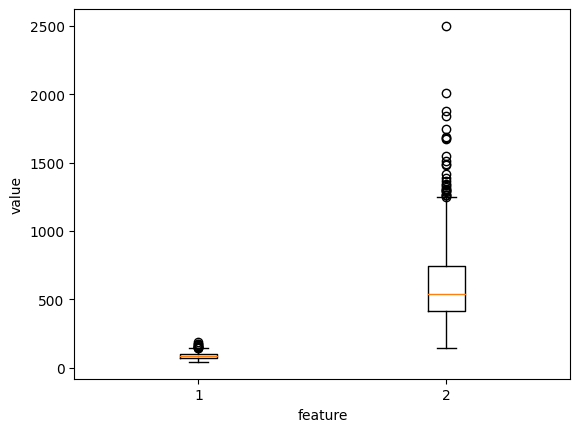

In [6]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:,2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

C:\Users\하영아\AppData\Local\Temp\ipykernel_42760\1698157251.py:23: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))


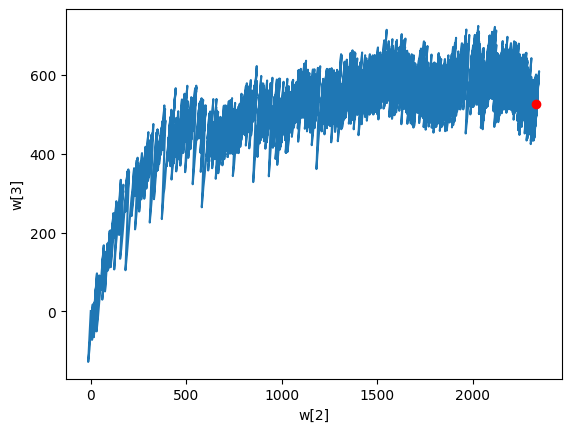

In [7]:
layer1=SingleLayer()
layer1.fit(x_train,y_train)
layer1.score(x_val,y_val)

w2, w3 = [], []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

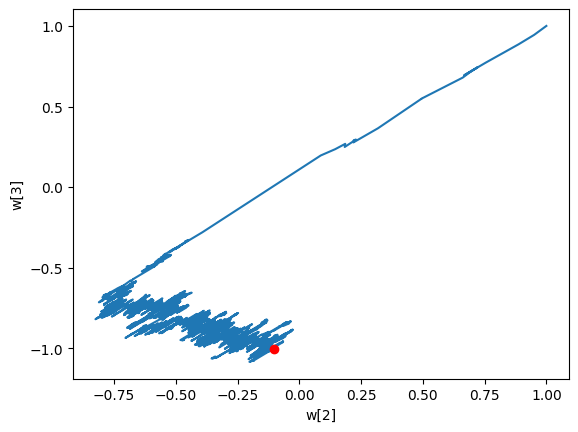

In [8]:
#scikitlearn's StandardScaler class equivalent standardization

train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train-train_mean) / train_std

layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2, w3 = [], []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w2, w3의 변화 비율이 비슷하기 때문에 가중치가 대각선 반향으로 이동

In [9]:
layer2.score(x_val, y_val)

0.37362637362637363

이 수치는 검증세트의 스케일은 정규화 해주지 않았기 때문, 검증세트도 표준화해야 한다.

* 함정: 훈련세트와 검증세트가 다른 비율로 전처리 될 수 있다. 
* 해결방법 : 훈련세트의 평균, 표준 편차를 사용하여 검증세트를 변환한다.

In [10]:
val_mean = np.mean(x_val, axis = 0) #특성별 평균
val_std = np.std(x_val, axis = 0)

x_val_scaled = (x_val - val_mean) / train_std
layer2.score(x_val_scaled, y_val)


0.967032967032967

### 과대적합과 과소적합

훈련세트에 대한 학습 곡선(learning curve)
![2](02.jpg)

1. 과대적합
    1. 훈련세트와 검증 세트의 성능차 크다 => 분산이 크다
    2. 원인 : 훈련세트에 다양한 패턴의 샘플이 없음
    3. 해결 : 더 많은 훈련 샘플, 가중치 제한으로 모델의 복잡도 저하
2. 과소적합
    1. 성능 자체가 낮다 =>편향이 크다
    2. 원인 : 모델이 충분히 복잡하지 않아 훈련 데이터에 있는 패턴을 모두 잡지 못함
    3. 해결 : 모델의 복잡도 증가, 가중치 규제 완화
3. 절충점, 좋은 모델

에포크/모델복잡도에 대한 학습 곡선(learning curve)
![3](03.jpg)

1. 손실
    1. 최적점 이전에 훈련세트 손실 감소, 검증세트의 손실 감소 => 과소적합
    2. 최적점 이후에 훈련세트 손실 감소, 검증세트의 손실 상승 => 과대적합
2. 정확도

#### 편향-분산 트레이드오프 
정의 : 과소적합(편향)된 모델과 과대적합(분산)된 모델 사이의 관계. 둘 다 완전히 잡을 수는 없으므로 적절한 중간 지점 선택

#### 경사 하강법의 에포크 횟수에 대한 손실
* SingleLayer()에 val_losses 변수, update_val_loss() 메서드 추가
* 검증세트의 출력값의 로지스틱 손실 함수 값을 계산해서 `update_val-loss()`호출

In [11]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled,y_train, x_val = x_val_scaled, y_val = y_val)
layer3.score(x_val_scaled, y_val)

0.967032967032967

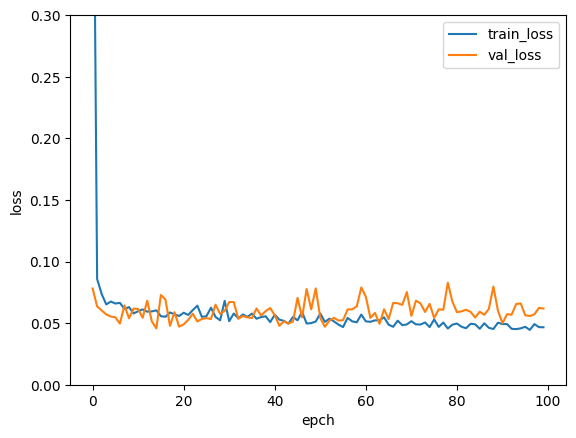

In [12]:
plt.ylim(0,0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epch')
plt.legend(['train_loss','val_loss'])
plt.show()

검증 손실이 20번째 에포크 이후에는 훈련 세트보다 높아지므로 20번까지만 훈련하면 된다-> 훈련 조기 종료로 과대적합 막기


In [13]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled,y_train, x_val = x_val_scaled, y_val = y_val, epochs = 20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

### 5-3 모델 규제 방법

규제(regularization): 과대적합을 해결하는 방법 중 하나로 가중치의 값이 커지지 않도록 제한하여 모델의 일반화 성능이 올라간다.

#### L1 규제 - 라쏘 모델

* 손실함수에 가중치의 절대값을 손실함수에 더한 것

$$||w||_1 = \sum^n_{i=1}|w_i|$$

![4](04.jpg)

$L$을 미분하여 얻은 도함수\* 학습률로 가중치 업데이트

![5](05.jpg)

* 규제 하이퍼파라미터 $\alpha$와 가중치의 부호의 곱을 더하면 경사하강법을 최적화할 수 있다. 
* 절편은 모델을 shifting만 하므로 대해 규제를 하지 않는다.
* 일부 가중치를 0으로 만들어 특성을 선택하는 효과를 낼 수 있다.
* 가중치의 크기에 따라 규제량이 변하지 않으므로($\alpha$에 많이 의존) 규제효과 좋지 않다.


### L2 규제 - 릿지 모델

* 손실함수에 가중치의 L2노름의 제곱을 더한 것

$$||w||_2 = \sqrt{\sum^n_{i=1}w_i^2}$$

![6](06.jpg)

$L$을 미분하여 얻은 도함수\* 학습률로 가중치 업데이트

![7](07.jpg)

* 규제 하이퍼파라미터 $\alpha$와 가중치의 곱을 더하면 경사하강법을 최적화할 수 있다. 
* 가중치값 자체가 그래디언트를 업데이트할 때 쓰이므로 규제가 조금 더 효과적이다.
* 가중치를 완전히 0으로 만들지 않아 복잡도가 떨어지지 않는다.

#### 데이터 세트에 규제 적용하기

In [14]:
#L1 norm
layer5 = SingleLayer(l1 = 0.001)
layer5.fit(x_train_scaled, y_train, epochs = 20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

In [15]:
#L1 norm
layer6 = SingleLayer(l2 = 0.001)
layer6.fit(x_train_scaled, y_train, epochs = 20)
layer6.score(x_val_scaled, y_val)

0.978021978021978

샘플 개수가 적어서 성능차이가 없이 보인다. > 둘 다 검증 샘플에 대해 옳게 예측한 샘플 개수 동일

In [16]:
#SGDClassifier 사용
sgd = SGDClassifier(loss = 'log_loss',penalty = 'l2', alpha = 0.001, random_state = 42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)


0.978021978021978

### 5-4 교차 검증

* 전체 데이터 샘플이 많지 않아 모델을 학습시키는 데이터가 부족할 때 교차 검증을 사용하면 좋다.

* 전체 데이터를 5등분하여 그중 한조각(테스트세트)만 빼놓고 다시 k등분하여 한조각씩 빼두어 검증에, 나머지는 훈련에 사용한다.
![8](08.jpg)

![9](09.jpg)

#### k-fold CV (k=10)

In [17]:
validation_scores = []
k = 10
bins = len(x_train) // k

for i in range(k) :
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start)) + list(range(end, len(x_train)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis = 0)
    train_std = np.std(train_fold, axis = 0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = SingleLayer(l2 = 0.01)
    lyr.fit(train_fold_scaled, train_target, epochs = 50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
    
print(np.mean(validation_scores))

0.9583333333333333


In [18]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sgd = SGDClassifier(loss = 'log_loss', penalty='l2', alpha = 0.001, random_state = 42)

pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv = 10, return_train_score = True)
print(scores)

{'fit_time': array([0.00299215, 0.00199437, 0.00199437, 0.00199413, 0.00099683,
       0.00099802, 0.0009973 , 0.00199342, 0.00199485, 0.00099802]), 'score_time': array([0.       , 0.       , 0.       , 0.       , 0.       , 0.0009973,
       0.       , 0.       , 0.       , 0.       ]), 'test_score': array([0.93478261, 0.95652174, 1.        , 0.95652174, 0.91304348,
       1.        , 1.        , 1.        , 1.        , 0.93333333]), 'train_score': array([0.99266504, 0.98777506, 0.99022005, 0.98777506, 0.98777506,
       0.98536585, 0.98536585, 0.98780488, 0.98292683, 0.98780488])}


In [19]:
np.mean(scores['test_score'])

0.9694202898550724